# USA Immigration Analysis
### Data Engineering Capstone Project

#### Project Summary
In this project, the US immigration data is collected and cleaned for analysing the immigration patterns and influence of factors such as Temperature and City Demographics on immigration.

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [1]:
# All imports and installs here
import pandas as pd
import seaborn as sns
import psycopg2
import configparser
import boto3

### Step 1: Scope the Project and Gather Data

#### Scope 
* The aim of the Immigration project is to analyse the Immigration data and join it with the US temperature, City demographics and Airports data to find any patterns. Four datasets are used in this project : data on immigration to the United States, data on airport codes, U.S. city demographics, and temperature data.
* These datasets are explored to clean the data and look for any data quality issues. A data model is created using the Star Schema and data pipelines are created connecting the pandas data to AWS RDS using AWS Redshift computation.
* In the end of this project, we will have SQL database created in AWS RDS. 

#### Describe and Gather Data 
The datasets used in the project are : 
Data Name: Immigration data
Data Description: Data on immigration to the United States
Data Source: https://www.trade.gov/national-travel-and-tourism-office

Data Name: Airport Codes
Data Description: Table of airport codes and corresponding cities
Data Source: https://datahub.io/core/airport-codes#data

Data Name: US City Demographics
Data Description: US Cities Demographics
Data Source: https://public.opendatasoft.com/explore/dataset/us-cities-demographics/export/

Table Name: USA Temperature
Data Description: Global Land Temperatures By City
Data Source: https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data

#### Step 1.1 Read the datasets in pandas dataframe

In [2]:
# Read Airport codes data
df_airport = pd.read_csv("airport-codes_csv.csv")

In [3]:
# Read City demographics data
df_dem = pd.read_csv("us-cities-demographics.csv", sep=';')

In [4]:
#Read US temperature data
fname = '../../data2/GlobalLandTemperaturesByCity.csv'
df_temp = pd.read_csv(fname)

In [150]:
# Read Immigration Data Labels Description data. This can be used when analysing immigration data
with open('./I94_SAS_Labels_Descriptions.SAS') as f:
    f_content = f.read()
    f_content = f_content.replace('\t', '')
def code_mapper(file, idx):
    f_content2 = f_content[f_content.index(idx):]
    f_content2 = f_content2[:f_content2.index(';')].split('\n')
    f_content2 = [i.replace("'", "") for i in f_content2]
    dic = [i.split('=') for i in f_content2[1:]]
    dic = dict([i[0].strip(), i[1].strip()] for i in dic if len(i) == 2)
    return dic
i94cit_res = code_mapper(f_content, "i94cntyl")
i94port = code_mapper(f_content, "i94prtl")
i94mode = code_mapper(f_content, "i94model")
i94addr = code_mapper(f_content, "i94addrl")
i94visa = {'1':'Business',
'2': 'Pleasure',
'3' : 'Student'}
i94addr

{'AL': 'ALABAMA',
 'AK': 'ALASKA',
 'AZ': 'ARIZONA',
 'AR': 'ARKANSAS',
 'CA': 'CALIFORNIA',
 'CO': 'COLORADO',
 'CT': 'CONNECTICUT',
 'DE': 'DELAWARE',
 'DC': 'DIST. OF COLUMBIA',
 'FL': 'FLORIDA',
 'GA': 'GEORGIA',
 'GU': 'GUAM',
 'HI': 'HAWAII',
 'ID': 'IDAHO',
 'IL': 'ILLINOIS',
 'IN': 'INDIANA',
 'IA': 'IOWA',
 'KS': 'KANSAS',
 'KY': 'KENTUCKY',
 'LA': 'LOUISIANA',
 'ME': 'MAINE',
 'MD': 'MARYLAND',
 'MA': 'MASSACHUSETTS',
 'MI': 'MICHIGAN',
 'MN': 'MINNESOTA',
 'MS': 'MISSISSIPPI',
 'MO': 'MISSOURI',
 'MT': 'MONTANA',
 'NC': 'N. CAROLINA',
 'ND': 'N. DAKOTA',
 'NE': 'NEBRASKA',
 'NV': 'NEVADA',
 'NH': 'NEW HAMPSHIRE',
 'NJ': 'NEW JERSEY',
 'NM': 'NEW MEXICO',
 'NY': 'NEW YORK',
 'OH': 'OHIO',
 'OK': 'OKLAHOMA',
 'OR': 'OREGON',
 'PA': 'PENNSYLVANIA',
 'PR': 'PUERTO RICO',
 'RI': 'RHODE ISLAND',
 'SC': 'S. CAROLINA',
 'SD': 'S. DAKOTA',
 'TN': 'TENNESSEE',
 'TX': 'TEXAS',
 'UT': 'UTAH',
 'VT': 'VERMONT',
 'VI': 'VIRGIN ISLANDS',
 'VA': 'VIRGINIA',
 'WV': 'W. VIRGINIA',
 'WA': 'WAS

In [6]:
# Read immigartaion data using Spark
from pyspark.sql import SparkSession

spark = SparkSession.builder.\
config("spark.jars.repositories", "https://repos.spark-packages.org/").\
config("spark.jars.packages", "saurfang:spark-sas7bdat:2.0.0-s_2.11").\
enableHiveSupport().getOrCreate()

df_spark = spark.read.format('com.github.saurfang.sas.spark').load('../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat')

In [7]:
#Write immigartion data in pyspark to parquet (Data already downloaded, Uncomment when redownloading the data)
# df_spark.write.parquet("sas_data")
# df_spark=spark.read.parquet("sas_data")

In [8]:
# Convert Spark data to csv (Data already downloaded, Uncomment when redownloading the data)
# df_spark.repartition(1)
# df_spark.coalesce(1).write.option("header",True).csv("datacsv_1")

In [10]:
# Read immigration data from csv
df_immigration =pd.read_csv('datacsv_1/part-00000-4e69ab9c-1d08-4dee-917c-251d00e04c77-c000.csv',low_memory=False)
df_immigration.head(2)

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,5748517.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,CA,20582.0,...,NaN,M,1976.0,10292016,F,NaN,QF,9.495387e+10,00011,B1
1,5748518.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,NV,20591.0,...,NaN,M,1984.0,10292016,F,NaN,VA,9.495562e+10,00007,B1


### Step 2: Explore and Assess the Data
#### Explore the Data 
The data is explored to identify data quality issues, like missing values, duplicate data, typos and outliers

#### Cleaning Steps
Steps necessary to clean the data:
*   Step 1 - Explore data to learn about data 
*   Step 2 - Find missing values
*   Step 3 - Handling missing data
**  Step 3.1 - Delete specific columns
**  Step 3.2 - Delete specific rows
**  Step 3.3 - Impute missing values
*    Step 4 - Find duplicate rows
*    Step 5 - Identify Outliers in numeric values
*    Step 6 - Detect errors, typos and misspelling with object data type

#### Functions to remove missing data and remove duplicates

In [11]:
# Handling missing data. 
# Remove missing columns and rows
def clean_df(df,col_criteria,row_criteria):   
    #Step 2 and 3
    null_percent  = (df.isnull().sum().sort_values(ascending=False))*100/len(df)
    for index, value in null_percent.iteritems():
        if value > col_criteria :
            df = df.drop(columns=[index],axis=1)
        elif value > row_criteria :
            df= df.dropna(subset=[index],how='any',axis=0)
    return df

In [12]:
# Duplicate rows drop function
def duplicates_remove(df):
    duplicateRows_df = df[df.duplicated()]
    if len(duplicateRows_df) > 0:
        df.drop_duplicates(subset=None, keep='first', inplace=True)
        return df
    elif len(duplicateRows_df) == 0:
        print ("There are no duplicate rows")
    

#### Explore and Clean Airport Data

In [14]:
# Explore data
df_airport.info()
df_airport.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55075 entries, 0 to 55074
Data columns (total 12 columns):
ident           55075 non-null object
type            55075 non-null object
name            55075 non-null object
elevation_ft    48069 non-null float64
continent       27356 non-null object
iso_country     54828 non-null object
iso_region      55075 non-null object
municipality    49399 non-null object
gps_code        41030 non-null object
iata_code       9189 non-null object
local_code      28686 non-null object
coordinates     55075 non-null object
dtypes: float64(1), object(11)
memory usage: 5.0+ MB


,elevation_ft
count,48069.000000
mean,1240.789677
std,1602.363459
min,-1266.000000
25%,205.000000
50%,718.000000
75%,1497.000000
max,22000.000000


In [28]:
#Impute missing values: Pandas wrongly recognised NA(North America) as NaN in continent column. Replace it by NA again
df_airport['continent'] = df_airport['continent'].fillna('NA')

In [29]:
# Delete specific columns: iata_code column is ~83% missing. So, let's delete this column
# Delete specific rows: local_code column is ~48% missing. 
#So, let's remove the rows with NA values in local_code column
df_airport = clean_df(df_airport,80,40)

In [30]:
# Find duplicate rows
duplicates_remove(df_airport)
#There are no duplicate rows

There are no duplicate rows


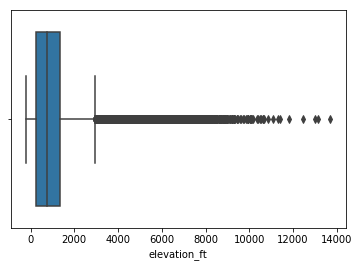

In [31]:
#Step 5: Identify Outliers in numeric values
sns.boxplot(df_airport['elevation_ft'])
#all the values are realistic elevations

In [32]:
#Step 6: Detect errors, typos and misspelling with object data type
df_airport['type'].value_counts()
df_airport['continent'].value_counts()
# No typos detected

NA    24221
SA     2234
EU      831
OC      709
AS      620
AF       61
AN       10
Name: continent, dtype: int64

#### Explore and  U.S.City Demographic Data

In [33]:
# Step 1 : Explore data
df_dem.info()
df_dem.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2875 entries, 0 to 2890
Data columns (total 12 columns):
City                      2875 non-null object
State                     2875 non-null object
Median Age                2875 non-null float64
Male Population           2875 non-null float64
Female Population         2875 non-null float64
Total Population          2875 non-null int64
Number of Veterans        2875 non-null float64
Foreign-born              2875 non-null float64
Average Household Size    2875 non-null float64
State Code                2875 non-null object
Race                      2875 non-null object
Count                     2875 non-null int64
dtypes: float64(6), int64(2), object(4)
memory usage: 292.0+ KB


,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,Count
count,2875.000000,2.875000e+03,2.875000e+03,2.875000e+03,2875.000000,2.875000e+03,2875.000000,2.875000e+03
mean,35.434678,9.744502e+04,1.018469e+05,1.992919e+05,9361.714435,4.069181e+04,2.742543,4.886379e+04
std,4.250501,2.167572e+05,2.320513e+05,4.487144e+05,13216.754474,1.558259e+05,0.433291,1.446315e+05
min,22.900000,2.928100e+04,2.734800e+04,6.321500e+04,416.000000,8.610000e+02,2.000000,9.800000e+01
25%,32.800000,3.931400e+04,4.122700e+04,8.043800e+04,3737.500000,9.224000e+03,2.430000,3.454000e+03
50%,35.300000,5.233600e+04,5.380900e+04,1.067820e+05,5397.000000,1.883000e+04,2.650000,1.378000e+04
75%,38.000000,8.668750e+04,8.958900e+04,1.753080e+05,9368.000000,3.400300e+04,2.950000,5.414650e+04
max,48.800000,4.081698e+06,4.468707e+06,8.550405e+06,156961.000000,3.212500e+06,4.980000,3.835726e+06


In [34]:
# Find missing values
(df_dem.isnull().sum().sort_values(ascending=False))*100/len(df_dem)

Count                     0.0
Race                      0.0
State Code                0.0
Average Household Size    0.0
Foreign-born              0.0
Number of Veterans        0.0
Total Population          0.0
Female Population         0.0
Male Population           0.0
Median Age                0.0
State                     0.0
City                      0.0
dtype: float64

In [35]:
#Handling missing data. 
#The missing values are very few. So, let's only remove the affected rows. Delete specific row: Average Household Size 
df_dem = clean_df(df_dem,80,0.1)

In [36]:
#Step 4: Find duplicate rows
duplicates_remove(df_dem)
#There are no duplicate rows

There are no duplicate rows


In [37]:
#Step 5: Detect errors, typos and misspelling with object data type
df_dem['City'].value_counts()
df_dem['State'].value_counts()
# No typos detected

California              676
Texas                   273
Florida                 219
Illinois                 91
Washington               85
Colorado                 80
Arizona                  80
Michigan                 79
Virginia                 70
North Carolina           70
Massachusetts            69
New Jersey               57
Georgia                  55
Minnesota                54
New York                 54
Indiana                  51
Maryland                 50
Ohio                     49
Utah                     48
Wisconsin                45
Nevada                   45
Missouri                 45
Tennessee                44
Oregon                   40
Louisiana                40
Connecticut              39
Kansas                   35
Alabama                  34
Iowa                     34
Pennsylvania             33
Oklahoma                 30
Arkansas                 29
South Carolina           24
New Mexico               20
Rhode Island             19
Idaho               

#### Explore and Clean World Temperature Data

In [38]:
# Step 1 : Explore data
df_temp.info()
df_temp.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8235082 entries, 0 to 8599210
Data columns (total 7 columns):
dt                               object
AverageTemperature               float64
AverageTemperatureUncertainty    float64
City                             object
Country                          object
Latitude                         object
Longitude                        object
dtypes: float64(2), object(5)
memory usage: 502.6+ MB


,AverageTemperature,AverageTemperatureUncertainty
count,8.235082e+06,8.235082e+06
mean,1.672743e+01,1.028575e+00
std,1.035344e+01,1.129733e+00
min,-4.270400e+01,3.400000e-02
25%,1.029900e+01,3.370000e-01
50%,1.883100e+01,5.910000e-01
75%,2.521000e+01,1.349000e+00
max,3.965100e+01,1.539600e+01


In [39]:
# Data Cleaning of world temperature data
# Find missing values
(df_temp.isnull().sum().sort_values(ascending=False))*100/len(df_temp)

Longitude                        0.0
Latitude                         0.0
Country                          0.0
City                             0.0
AverageTemperatureUncertainty    0.0
AverageTemperature               0.0
dt                               0.0
dtype: float64

In [40]:
#Handling missing data. 
#The missing values are very few. So, let's only remove the affected rows. Delete specific rows: AverageTemperature 
df_temp = clean_df(df_temp,80,4)

In [41]:
#Step 4: Find duplicate rows
duplicates_remove(df_temp)
#There are no duplicate rows

There are no duplicate rows


In [42]:
#Step 5: Identify Outliers in numeric values
df_temp.describe()
# From the statistics, all values are ina realistic range

,AverageTemperature,AverageTemperatureUncertainty
count,8.235082e+06,8.235082e+06
mean,1.672743e+01,1.028575e+00
std,1.035344e+01,1.129733e+00
min,-4.270400e+01,3.400000e-02
25%,1.029900e+01,3.370000e-01
50%,1.883100e+01,5.910000e-01
75%,2.521000e+01,1.349000e+00
max,3.965100e+01,1.539600e+01


In [43]:
#Step 6: Detect errors, typos and misspelling with object data type
df_temp['City'].value_counts()
df_temp['Country'].value_counts()
# No typos detected

India                       960548
China                       819132
United States               661524
Brazil                      451645
Russia                      448663
Japan                       356467
Indonesia                   273295
Germany                     256446
United Kingdom              215288
Mexico                      208020
Nigeria                     157012
Spain                       156528
Turkey                      147086
Iran                        146168
Italy                       132972
Philippines                 124865
Pakistan                    123265
Poland                      120308
France                      113976
South Africa                 93653
Venezuela                    83378
Colombia                     79246
Romania                      79150
Netherlands                  75984
Ukraine                      75981
Canada                       71444
Malaysia                     64723
Vietnam                      62221
Taiwan              

#### Explore and Clean I94 Immigration Data

In [44]:
# Explore and clean I94 Immigration Data
# Explore data
df_immigration.info()
df_immigration.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3096313 entries, 0 to 3096312
Data columns (total 28 columns):
cicid       float64
i94yr       float64
i94mon      float64
i94cit      float64
i94res      float64
i94port     object
arrdate     float64
i94mode     float64
i94addr     object
depdate     float64
i94bir      float64
i94visa     float64
count       float64
dtadfile    float64
visapost    object
occup       object
entdepa     object
entdepd     object
entdepu     object
matflag     object
biryear     float64
dtaddto     object
gender      object
insnum      object
airline     object
admnum      float64
fltno       object
visatype    object
dtypes: float64(14), object(14)
memory usage: 661.4+ MB


,cicid,i94yr,i94mon,i94cit,i94res,arrdate,i94mode,depdate,i94bir,i94visa,count,dtadfile,biryear,admnum
count,3.096313e+06,3096313.0,3096313.0,3.096313e+06,3.096313e+06,3.096313e+06,3.096074e+06,2.953856e+06,3.095511e+06,3.096313e+06,3096313.0,3.096312e+06,3.095511e+06,3.096313e+06
mean,3.078652e+06,2016.0,4.0,3.049069e+02,3.032838e+02,2.055985e+04,1.073690e+00,2.057395e+04,4.176761e+01,1.845393e+00,1.0,2.016042e+07,1.974232e+03,7.082885e+10
std,1.763278e+06,0.0,0.0,2.100269e+02,2.085832e+02,8.777339e+00,5.158963e-01,2.935697e+01,1.742026e+01,3.983910e-01,0.0,5.001513e+01,1.742026e+01,2.215442e+10
min,6.000000e+00,2016.0,4.0,1.010000e+02,1.010000e+02,2.054500e+04,1.000000e+00,1.517600e+04,-3.000000e+00,1.000000e+00,1.0,2.013081e+07,1.902000e+03,0.000000e+00
25%,1.577790e+06,2016.0,4.0,1.350000e+02,1.310000e+02,2.055200e+04,1.000000e+00,2.056100e+04,3.000000e+01,2.000000e+00,1.0,2.016041e+07,1.962000e+03,5.603523e+10
50%,3.103507e+06,2016.0,4.0,2.130000e+02,2.130000e+02,2.056000e+04,1.000000e+00,2.057000e+04,4.100000e+01,2.000000e+00,1.0,2.016042e+07,1.975000e+03,5.936094e+10
75%,4.654341e+06,2016.0,4.0,5.120000e+02,5.040000e+02,2.056700e+04,1.000000e+00,2.057900e+04,5.400000e+01,2.000000e+00,1.0,2.016042e+07,1.986000e+03,9.350987e+10
max,6.102785e+06,2016.0,4.0,9.990000e+02,7.600000e+02,2.057400e+04,9.000000e+00,4.542700e+04,1.140000e+02,3.000000e+00,1.0,2.016092e+07,2.019000e+03,9.991557e+10


In [45]:
# Data Cleaning of I94 Immigration Data
# Find missing values
(df_immigration.isnull().sum().sort_values(ascending=False))*100/len(df_immigration)

entdepu     99.987340
occup       99.737559
insnum      96.327632
visapost    60.757746
gender      13.379429
i94addr      4.931220
depdate      4.600859
matflag      4.470769
entdepd      4.470769
airline      2.700890
fltno        0.631364
i94bir       0.025902
biryear      0.025902
dtaddto      0.015405
i94mode      0.007719
entdepa      0.007687
dtadfile     0.000032
i94cit       0.000000
i94mon       0.000000
i94port      0.000000
i94yr        0.000000
i94res       0.000000
visatype     0.000000
arrdate      0.000000
i94visa      0.000000
count        0.000000
admnum       0.000000
cicid        0.000000
dtype: float64

In [46]:
#Handling missing data. 
#Delete specific columns: entdepu, occup, insnum  column are >90% missing. So, let's delete these columns
#Delete specific rows: gender column
#let's remove the rows with NA values in gender, depdate, matflag, entdepd, i94addr, airline column
df_immigration = clean_df(df_immigration,60,2)

In [47]:
#Step 4: Find duplicate rows
duplicates_remove(df_immigration)
#There are no duplicate rows

There are no duplicate rows


In [48]:
#Step 5: Identify Outliers in numeric values
df_immigration.describe()
# From the statistics, all values are ina realistic range

,cicid,i94yr,i94mon,i94cit,i94res,arrdate,i94mode,depdate,i94bir,i94visa,count,dtadfile,biryear,admnum
count,2.384933e+06,2384933.0,2384933.0,2.384933e+06,2.384933e+06,2.384933e+06,2.384933e+06,2.384933e+06,2.384913e+06,2.384933e+06,2384933.0,2.384933e+06,2.384913e+06,2.384933e+06
mean,3.052079e+06,2016.0,4.0,3.156394e+02,3.151612e+02,2.055987e+04,1.002926e+00,2.057462e+04,4.152748e+01,1.852132e+00,1.0,2.016042e+07,1.974473e+03,7.190694e+10
std,1.759085e+06,0.0,0.0,2.154832e+02,2.145281e+02,8.849418e+00,6.210779e-02,2.316846e+01,1.736532e+01,3.850102e-01,0.0,4.258302e+01,1.736532e+01,2.197606e+10
min,1.500000e+01,2016.0,4.0,1.010000e+02,1.010000e+02,2.054500e+04,1.000000e+00,2.022600e+04,0.000000e+00,1.000000e+00,1.0,2.016040e+07,1.916000e+03,0.000000e+00
25%,1.557185e+06,2016.0,4.0,1.350000e+02,1.310000e+02,2.055200e+04,1.000000e+00,2.056100e+04,3.000000e+01,2.000000e+00,1.0,2.016041e+07,1.962000e+03,5.608648e+10
50%,3.083178e+06,2016.0,4.0,2.450000e+02,2.130000e+02,2.056000e+04,1.000000e+00,2.057000e+04,4.100000e+01,2.000000e+00,1.0,2.016042e+07,1.975000e+03,5.944449e+10
75%,4.563084e+06,2016.0,4.0,5.750000e+02,5.280000e+02,2.056800e+04,1.000000e+00,2.057900e+04,5.400000e+01,2.000000e+00,1.0,2.016042e+07,1.986000e+03,9.360083e+10
max,6.083367e+06,2016.0,4.0,9.990000e+02,7.600000e+02,2.057400e+04,9.000000e+00,2.071600e+04,1.000000e+02,3.000000e+00,1.0,2.016091e+07,2.016000e+03,9.701082e+10


In [49]:
#Step 6: Detect errors, typos and misspelling with object data type
df_immigration['visatype'].value_counts()
# No typos detected

WT     1006597
B2      903921
WB      181142
B1      177110
GMT      67840
F1       24213
E2       14779
E1        2936
I         2869
F2        1605
CP         893
M1         662
I1         201
GMB        127
M2          28
CPL          8
SBP          2
Name: visatype, dtype: int64

### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
Star schema is used to model the 4 datasets. The fact table at the centre is the I94 Immigration Data
and the Dimension tables (the star points) are the Airport codes data, US City Demographics data and the US Temperature data
The reason of choosing Star schema is that all the dimension tables are adding value to the fact table which will be used for any analysis. 
![image](data_model.png) 

#### 3.2 Mapping Out Data Pipelines
List the steps necessary to pipeline the data into the chosen data model
1. Read all the five datasets
2. Clean the datasets
3. Create sql data models 
4.Insert the data to sql tables
5. Run analysis on the data




![image](data_pipeline.png)
                            

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

#### Create SQL Table statements 

In [51]:
#create immigration data table
immigration_I94_table_create= """
  CREATE TABLE IF NOT EXISTS public.i94_immigration (
    cicid    FLOAT PRIMARY KEY,
    Year     FLOAT,
    Month    FLOAT,
    i94cit      FLOAT,
    i94res      FLOAT,
    i94port  VARCHAR,
    arrdate  FLOAT,
    i94mode     FLOAT,
    addr     VARCHAR,
    depdate  FLOAT,
    i94bir      FLOAT, 
    i94visa     FLOAT,
    count    FLOAT, 
    dtadfile VARCHAR,
    entdepa   VARCHAR,
    entdepd   VARCHAR,
    matflag  VARCHAR,
    biryear  FLOAT,
    dtaddto  text,
    gender   VARCHAR, 
    airline  VARCHAR,
    admnum   FLOAT,
    fltno    VARCHAR,
    visatype VARCHAR  
);
"""

In [52]:
#create airport codes table
airport_codes_table_create = """
CREATE TABLE IF NOT EXISTS public.airport_codes(
ident           VARCHAR PRIMARY KEY,
type            VARCHAR,
name            VARCHAR,
elevation_ft    FLOAT,
continent       VARCHAR,
iso_country     VARCHAR,
iso_region      VARCHAR,
municipality    VARCHAR,
gps_code        VARCHAR,
local_code      VARCHAR,
coordinates     VARCHAR
);

"""

In [119]:
# Create US City Demographics table
uscity_demographics_table_create = """
CREATE TABLE IF NOT EXISTS public.city_demographics(
City                      VARCHAR,
State                     VARCHAR,
Median_Age                FLOAT,
Male_Population           FLOAT,
Female_Population         FLOAT,
Total_Population          int,
Number_of_Veterans        FLOAT,
Foreign_born              FLOAT,
Average_Household_Size    FLOAT,
State_Code                VARCHAR,
Race                      VARCHAR,
Count                     int
);
"""

In [54]:
# Create US Temperature table
us_temperature_table_create = """
CREATE TABLE IF NOT EXISTS public.us_temperature(
dt                               VARCHAR PRIMARY KEY,
AverageTemperature               FLOAT,
AverageTemperatureUncertainty    FLOAT,
City                             VARCHAR,
Country                          VARCHAR,
Latitude                         VARCHAR,
Longitude                        VARCHAR
);
"""

#### Drop SQL tables statements

In [55]:
# SQL statements to drop tables
Immigration_table_drop = "DROP TABLE IF EXISTS i94_immigration"
AirportCodes_table_drop = "DROP TABLE IF EXISTS airport_codes"
City_Demographics_table_drop = "DROP TABLE IF EXISTS city_demographics"
Us_temperature_drop = "DROP TABLE IF EXISTS us_temperature"

#### Insert rows to SQL tables statements

In [56]:
# SQL statements to insert tables
Immigration_I94_insert = ("""
                        INSERT INTO i94_immigration 
                        VALUES (%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s);                
                           """)

Airport_Codes_insert = ("""
                            INSERT INTO airport_codes 
                             VALUES(%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s);
                             """)
    
US_Demographics_insert = ("""
                            INSERT INTO city_demographics 
                             VALUES(%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s);
                        """)

US_Temperature_insert = ("""
                            INSERT INTO us_temperature 
                            VALUES(%s, %s, %s, %s, %s, %s, %s);
                        """)


#### Drop SQL Tables in AWS RDS

In [57]:
# Drop Tables function
def drop_RDS_tables(setup_file,drop_table):
    config = configparser.ConfigParser()
    config.read(setup_file)
    conn = psycopg2.connect("host={} dbname={} user={} password={} port={}".format(*config['CLUSTER'].values()))
    cur = conn.cursor() 
    cur.execute(drop_table)
    conn.commit()
    conn.close()

In [58]:
drop_table_queries = [Immigration_table_drop, AirportCodes_table_drop, City_Demographics_table_drop, Us_temperature_drop]

In [59]:
# Drop Tables
for queries in drop_table_queries:
    drop_RDS_tables('dwh.cfg',queries)

#### Create SQL Tables in AWS RDS

In [60]:
# Create Tables function
def create_RDS_tables(setup_file,create_table):
    config = configparser.ConfigParser()
    config.read(setup_file)
    conn = psycopg2.connect("host={} dbname={} user={} password={} port={}".format(*config['CLUSTER'].values()))
    cur = conn.cursor() 
    cur.execute(create_table)
    conn.commit()
    conn.close()

In [61]:
create_table_queries = [immigration_I94_table_create, airport_codes_table_create, uscity_demographics_table_create, us_temperature_table_create]

In [62]:
# Create Tables
for queries in create_table_queries:
    create_RDS_tables('dwh.cfg',queries)

#### Insert Rows in tables in AWS RDS 

In [80]:
# Insert data to SQL tables function
def insert_data_to_RDS_tables(setup_file,df,insert_data):
    config = configparser.ConfigParser()
    config.read(setup_file)
    conn = psycopg2.connect("host={} dbname={} user={} password={} port={}".format(*config['CLUSTER'].values()))
    cur = conn.cursor()
    for index, row in df[:100].iterrows():
        cur.execute(insert_data, list(row))
        conn.commit()
    conn.close()

In [67]:
# Insert data to Immigration Table
insert_data_to_RDS_tables('dwh.cfg',df_immigration, Immigration_I94_insert)

In [85]:
# Function to Check is insert function worked
def confirm_insertion_of_rows(setup_file,table_name):
    config = configparser.ConfigParser()
    config.read(setup_file)
    conn = psycopg2.connect("host={} dbname={} user={} password={} port={}".format(*config['CLUSTER'].values()))
    cur = conn.cursor()
    cur.execute("""SELECT * FROM {}""".format(table_name))
    row = cur.fetchone()
    print(row)

In [87]:
confirm_insertion_of_rows('dwh.cfg','i94_immigration')

(5748517.0, 2016.0, 4.0, 245.0, 438.0, 'LOS', 20574.0, 1.0, 'CA', 20582.0, 40.0, 1.0, 1.0, '20160430.0', 'G', 'O', 'M', 1976.0, '10292016', 'F', 'QF', 94953870030.0, '00011', 'B1')


In [81]:
# Insert data to Airport Table
insert_data_to_RDS_tables('dwh.cfg',df_airport, Airport_Codes_insert)

In [86]:
confirm_insertion_of_rows('dwh.cfg','airport_codes')

('00A', 'heliport', 'Total Rf Heliport', 11.0, 'NA', 'US', 'US-PA', 'Bensalem', '00A', '00A', '-74.93360137939453, 40.07080078125')


In [88]:
# Insert data to Demographics Table
insert_data_to_RDS_tables('dwh.cfg',df_dem, US_Demographics_insert)

In [89]:
confirm_insertion_of_rows('dwh.cfg','city_demographics')

('Silver Spring', 'Maryland', 33.8, 40601.0, 41862.0, 82463, 1562.0, 30908.0, 2.6, 'MD', 'Hispanic or Latino', 25924)


In [90]:
# Insert data to Temperature Table
insert_data_to_RDS_tables('dwh.cfg',df_temp, US_Temperature_insert)

In [91]:
confirm_insertion_of_rows('dwh.cfg','us_temperature')

('1743-11-01', 6.068, 1.737, 'Århus', 'Denmark', '57.05N', '10.33E')


#### Insert Rows in tables in AWS RDS 

In [73]:
#### Insert Rows in City Demographics table
conn = psycopg2.connect("host={} dbname={} user={} password={} port={}".format(*config['CLUSTER'].values()))
cur = conn.cursor() 
for index, row in df_dem.iterrows():
    cur.execute(US_Demographics_insert,([row.City ,row.State, row['Median Age'], row['Male Population'],row['Female Population'],\
        row['Total Population'],row['Number of Veterans'], row['Foreign-born'], row['Average Household Size'], row['State Code'],\
        row.Race,row.Count]))
conn.commit()
conn.close()    

In [75]:
#### Insert Rows in Airport Codes table
conn = psycopg2.connect("host={} dbname={} user={} password={} port={}".format(*config['CLUSTER'].values()))
cur = conn.cursor() 
for index, row in df_airport[:1000].iterrows():
    cur.execute(Airport_Codes_insert,([row.ident, row.type, row.name ,row.elevation_ft,row.continent, row.iso_country, row.iso_region ,row.municipality,row.gps_code,\
                                       row.local_code ,row.coordinates]))
conn.commit()
conn.close()

In [33]:
#### Insert Rows in US Temperature table
conn = psycopg2.connect("host={} dbname={} user={} password={} port={}".format(*config['CLUSTER'].values()))
cur = conn.cursor()
for index, row in df_temp[:1000].iterrows():
    cur.execute(US_Temperature_insert,([row['dt'],row.AverageTemperature, row.AverageTemperatureUncertainty, row.City,row.Country,row.Latitude,row.Longitude]))
conn.commit()
conn.close() 

In [39]:
#### Insert Rows in Immigration table
conn = psycopg2.connect("host={} dbname={} user={} password={} port={}".format(*config['CLUSTER'].values()))
cur = conn.cursor()
for index, row in df_immigration[:1000].iterrows():
    cur.execute(Immigration_I94_insert,([row.cicid,row.i94yr,row.i94mon,row.i94cit,row.i94res,row.i94port,row.arrdate,row.i94mode,row.i94addr,row.depdate,row.i94bir,row.i94visa,\
                row['count'],row.dtadfile,row.entdepa,row.entdepd,row.matflag,row.biryear,row.dtaddto,row.gender,row.airline,row.admnum,row.fltno,row.visatype]))
conn.commit()
conn.close()

#### 4.2 Data Quality Checks
The data quality checks performed on all the 4 datasets are :
* Check for uniqueness of primary keys in the tables
* Data validation is done to check if the number of rows are more than zero
* Data validation is done to check if the number of rows are same as the number of rows in the input data

In [115]:
# Function to Check for uniqueness of primary keys
def unique_idcheck(setup_file,table_name, column_name):
    config = configparser.ConfigParser()
    config.read(setup_file)
    con = psycopg2.connect("host={} dbname={} user={} password={} port={}".format(*config['CLUSTER'].values()))
    df = pd.read_sql("SELECT * FROM {}".format(table_name), con=con)
    duplicateRows = df[df.duplicated([column_name])]
    if len(duplicateRows) > 0:
        print('Unique ID test failed for {}'.format(table_name))
        return duplicateRows
    elif len(duplicateRows) == 0:
        print ("Unique ID test passed for {}. There are no duplicate rows".format(table_name))

In [118]:
# Quality check: Unique IDs
unique_idcheck('dwh.cfg','i94_immigration', 'cicid')
unique_idcheck('dwh.cfg','us_temperature', 'dt')
unique_idcheck('dwh.cfg', 'airport_codes', 'ident')

Unique ID test passed for i94_immigration. There are no duplicate rows
Unique ID test passed for us_temperature. There are no duplicate rows
Unique ID test passed for airport_codes. There are no duplicate rows


In [99]:
# Function to Check for number of rows in sql table
def data_rows_validation(setup_file,ip_row_count,table_name):
    config = configparser.ConfigParser()
    config.read(setup_file)
    data_rows = ip_row_count
#     data_rows = len(df)  only use when whole dataframe is inserted to sql
    conn = psycopg2.connect("host={} dbname={} user={} password={} port={}".format(*config['CLUSTER'].values()))
    cur = conn.cursor()
    cur.execute("""SELECT COUNT(*) FROM {}""".format(table_name))
    row = cur.fetchone()
    sql_rows = row[0]
    conn.commit()
    if sql_rows < 1:
        raise ValueError("Data quality check failed. {} Table contained 0 rows".format(table_name))
    elif sql_rows != data_rows:
        raise ValueError("Data quality check failed for {}. Not all rows have been copied to Redshift".format(table_name))
    else: print("Quality check passed for {}".format(table_name))

In [101]:
# Quality check: Check if No. of rows same as in the input pandas dataframe and rows > 0. Below, 100 is the input row count as only 100 rows inserted for now
data_rows_validation('dwh.cfg',100,'i94_immigration')
data_rows_validation('dwh.cfg',100,'city_demographics')
data_rows_validation('dwh.cfg',100,'us_temperature')
data_rows_validation('dwh.cfg',100,'airport_codes')

Quality check passed for i94_immigration
Quality check passed for city_demographics
Quality check passed for us_temperature
Quality check passed for airport_codes


#### ETL Process Result 

In [141]:
def read_sql_table(setup_file,table_name):
    config = configparser.ConfigParser()
    config.read(setup_file)
    con = psycopg2.connect("host={} dbname={} user={} password={} port={}".format(*config['CLUSTER'].values()))
    df = pd.read_sql("SELECT * FROM {} LIMIT 5".format(table_name), con=con)
    print(table_name)
    return df

In [143]:
read_sql_table('dwh.cfg','i94_immigration')

i94_immigration


,cicid,year,month,i94cit,i94res,i94port,arrdate,i94mode,addr,depdate,...,entdepa,entdepd,matflag,biryear,dtaddto,gender,airline,admnum,fltno,visatype
0,5748517.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,CA,20582.0,...,G,O,M,1976.0,10292016,F,QF,9.495387e+10,00011,B1
1,5748518.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,NV,20591.0,...,G,O,M,1984.0,10292016,F,VA,9.495562e+10,00007,B1
2,5748519.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,WA,20582.0,...,G,O,M,1987.0,10292016,M,DL,9.495641e+10,00040,B1
3,5748520.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,WA,20588.0,...,G,O,M,1987.0,10292016,F,DL,9.495645e+10,00040,B1
4,5748521.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,WA,20588.0,...,G,O,M,1988.0,10292016,M,DL,9.495639e+10,00040,B1


In [144]:
read_sql_table('dwh.cfg','airport_codes')

airport_codes


,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11.0,NA,US,US-PA,Bensalem,00A,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NA,US,US-KS,Leoti,00AA,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450.0,NA,US,US-AK,Anchor Point,00AK,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820.0,NA,US,US-AL,Harvest,00AL,00AL,"-86.77030181884766, 34.86479949951172"
4,00AS,small_airport,Fulton Airport,1100.0,NA,US,US-OK,Alex,00AS,00AS,"-97.8180194, 34.9428028"


In [145]:
read_sql_table('dwh.cfg','us_temperature')

us_temperature


,dt,averagetemperature,averagetemperatureuncertainty,city,country,latitude,longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1744-04-01,5.788,3.624,Århus,Denmark,57.05N,10.33E
2,1744-05-01,10.644,1.283,Århus,Denmark,57.05N,10.33E
3,1744-06-01,14.051,1.347,Århus,Denmark,57.05N,10.33E
4,1744-07-01,16.082,1.396,Århus,Denmark,57.05N,10.33E


In [146]:
read_sql_table('dwh.cfg','city_demographics')

city_demographics


,city,state,median_age,male_population,female_population,total_population,number_of_veterans,foreign_born,average_household_size,state_code,race,count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402


In [148]:
df_immigration.head(2)

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,...,entdepa,entdepd,matflag,biryear,dtaddto,gender,airline,admnum,fltno,visatype
0,5748517.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,CA,20582.0,...,G,O,M,1976.0,10292016,F,QF,9.495387e+10,00011,B1
1,5748518.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,NV,20591.0,...,G,O,M,1984.0,10292016,F,VA,9.495562e+10,00007,B1


#### 4.3 Data dictionary 
A data dictionary is created for the data model. 

##### Table Name: us_temperature
Data Description: Global Land Temperatures By City
Data Source: https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data

|Term                         |DataType|Description                                   |Example   |
|-----------------------------|--------|----------------------------------------------|----------|
|dt                           |VARCHAR |Date                                          |1744-03-01|      
|AverageTemperature           |FLOAT   |average land temperature in celsius           |6.068     |
|AverageTemperatureUncertainty|FLOAT   |the 95% confidence interval around the average|1.737     |
|City                         |VARCHAR |Name of the city where temperature is measured|Arhus     |
|Country                      |VARCHAR |Name of the corresponding Country             |Denmark   |
|Latitude                     |VARCHAR |Corresponding Coordinate                      |57.05N    |
|Longitude                    |VARCHAR |Corresponding Coordinate                      |10.33E    |

##### Table Name: city_demographics
Data Description: US Cities Demographics
Data Source: https://public.opendatasoft.com/explore/dataset/us-cities-demographics/export/

|Term                  |DataType|Description                                 |Example   |
|----------------------|--------|--------------------------------------------|----------|
|City                  |VARCHAR |City name                                   |Newark    |      
|State                 |VARCHAR |State in which the city is located          |New Jersey|
|Median_Age            |FLOAT   |Median age of the population                |34.6      |
|Male_Population       |FLOAT   |Number of males in the city                 |138040.0  |
|Female_Population     |FLOAT   |Number of females in the city               |143873.0  |
|Total_Population      |INT     |Total population in the city                |281913    |
|Number_of_Veterans    |FLOAT   |Number of vetrans                           |5829.0    |
|Foreign_born          |FLOAT   |Number of foreign born people               |86253.0   |
|Average_Household_Size|FLOAT   |Average household size                      |2.73      |
|State_Code            |VARCHAR |State code                                  |NJ        |
|Race                  |VARCHAR |Race of people                              |White     |
|Count                 |INT     |Number of people with the corresponding race|76402     |

##### Table Name: airport_codes
Data Description: Table of airport codes and corresponding cities
Data Source: https://datahub.io/core/airport-codes#data

|Term        |DataType|Description               |Example                |
|------------|--------|--------------------------|-----------------------|
|ident       |VARCHAR |Identification number     |00AS                   |      
|type        |VARCHAR |airport type              |small_airport          |
|name        |VARCHAR |Name of Airport           |Fulton Airport         |
|elevation_ft|FLOAT   |Elevation of airport in ft|1100.0                 |
|continent   |VARCHAR |Continent of airport      |NA                     |
|iso_country |VARCHAR |Country of airport        |US                     |
|iso_region  |VARCHAR |Region of airport         |US-OK                  |
|municipality|VARCHAR |Municipality of airport   |Alex                   |
|gps_code    |VARCHAR |GPS code of airport       |00AS                   |
|local_code  |VARCHAR |Local code of airport     |00AS                   |
|coordinates |VARCHAR |Coordinates of airport    |-97.8180194, 34.9428028|


##### Table Name: i94_immigration
Data Description: Data on immigration to the United States
Data Source: https://www.trade.gov/national-travel-and-tourism-office

|Term    |DataType|Description                                                                       |Example     |
|--------|--------|----------------------------------------------------------------------------------|------------|
|cicid   |FLOAT   |Identification number                                                             |5748521.0   |      
|Year    |FLOAT   |Year                                                                              |2016.0      |
|Month   |FLOAT   |Month                                                                             |4.0         |
|i94cit  |FLOAT   |City code                                                                         |245.0       |
|i94res  |FLOAT   |Res Code                                                                          |438.0       |
|i94port |VARCHAR |Port code                                                                         |LOS         |
|arrdate |FLOAT   |Arrival date                                                                      |20574.0     |
|i94mode |FLOAT   |mode of transport                                                                 |1.0         |
|addr    |VARCHAR |City Address                                                                      |WA          |
|depdate |FLOAT   |Departure Date from the USA                                                       |20588.0     |
|i94bir  |FLOAT   |Age of Respondent in Years                                                        |28          |
|i94visa |FLOAT   |Visa Type                                                                         |00AS        |      
|count   |FLOAT   |Used for summary statistics                                                       |1.0         |
|dtadfile|VARCHAR |Character Date Field - Date added to I-94 Files                                   |20160430.0  |
|entdepa |VARCHAR |Arrival Flag - admitted or paroled into the U.S.                                  |G           |
|entdepd |VARCHAR |Departure Flag - Departed, lost I-94 or is deceased                               |O           |
|matflag |VARCHAR |Match flag - Match of arrival and departure records                               |M           |
|biryear |FLOAT   |4 digit year of birth                                                             |1988.0      |
|dtaddto |text    |Character Date Field Date to which admitted to U.S                                |10292016    |
|gender  |VARCHAR |Non-immigrant sex                                                                 |M           |
|airline |VARCHAR |Airline used to arrive in U.S.                                                    |DL          |
|admnum  |FLOAT   |Admission Number                                                                  |9.495639e+10|
|fltno   |VARCHAR |Flight number of Airline used to arrive in U.S.                                   |00040       |
|visatype|VARCHAR |Class of admission legally admitting the non-immigrant to temporarily stay in U.S.|B1          |

#### Step 5: Complete Project Write Up


#### Rationale for the choice of tools and technologies for the project.
Pandas : To read, analyse, clean the data
Seaborn : To display the data and look for any outliers
AWS Redshift : To run the jobs on Cloud
AWS RDS : To store the tables in SQL database provided by AWS

#### Propose how often the data should be updated and why.
As the data collected will be used to look for immigration patterns, a monthly to yearly update of the data is preferred. A monthly update can inform if any world situation has caused the increase/decrease in the influx of immigrants. A yearly update is for a more broad analysis of year to year changes in immigration and any anomaly can indicate changes such as changes with the world economy  

#### A description of how to approach the problem differently under the following scenarios:
##### The data was increased by 100x.
 
 With the increase in data, we will require Cloud and Spark.
 Cloud : Cloud computing is needed to analyse and ingest huge datasets (unless on-premise data center can handle huge data. Cloud is more flexible though)
 Apache Spark : As the data increases, partitions need to be set up to ingest data in chunks. 

##### The data populates a dashboard that must be updated on a daily basis by 7am every day.
 
As the data must be updated everyday, a job scheduler such as Apache Airflow is required.Airflow can help with automated trigerring, scheduling and informing the status of the jobs. 

##### The database needed to be accessed by 100+ people.
 
 Using the IAM user role access in AWS, users can be provided access upon user authentication

In [83]:

config = configparser.ConfigParser()
config.read_file(open('dwh.cfg'))

KEY                    = config.get('AWS','KEY')
SECRET                 = config.get('AWS','SECRET')

In [84]:
redshift = boto3.client('redshift',
                       region_name="us-west-2",
                       aws_access_key_id=KEY,
                       aws_secret_access_key=SECRET
                       )

In [86]:
##Delete Cloud resources (uncomment to delete)
# redshift.delete_cluster( ClusterIdentifier="redshift-cluster-1",  SkipFinalClusterSnapshot=True)
